In [1]:
from backpack_predictor import (
    prepare_data, check_model_dicts, create_splits, train_eval_cv
)
from backpack_predictor.features import target, baseline_features, feature_list, cat_cols
from backpack_predictor.model_config import model_dict# l1_models, l2_models, l3_models

%load_ext autoreload
%autoreload 2

from datetime import datetime
import time
import numpy as np
import pandas as pd
from scipy.stats import skew, chisquare, kruskal, ks_2samp, chi2_contingency

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import KBinsDiscretizer, TargetEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import root_mean_squared_error

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

test_df = pd.read_csv(r'..//data//test.csv')
train_df = pd.read_csv(r'..//data//train.csv')
train_extra_df = pd.read_csv(r'..//data//training_extra.csv')
train_df = pd.concat([train_df, train_extra_df], ignore_index=True)

# Apply function to train and test datasets
train_df = prepare_data(train_df, is_train=True)
test_df = prepare_data(test_df, is_train=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
from backpack_predictor.model_config import model_dict

In [27]:
models = model_dict['models']
features_to_TE = model_dict['features_to_TE']
features_te = model_dict['features_te']

for model in models:
    check_model_dicts(model)

2025-02-21 08:13:11.379 | INFO     | backpack_predictor.model:check_model_dicts:44 - Passed checks for model_dict.
2025-02-21 08:13:11.379 | INFO     | backpack_predictor.model:check_model_dicts:44 - Passed checks for model_dict.


In [28]:
next_df = train_df.copy()

for model in models:
    data_splits = create_splits(next_df, features_to_TE, features_te, target, n_splits=5)
    next_df = train_eval_cv(model, data_splits, target)

2025-02-21 08:13:15.243 | INFO     | backpack_predictor.model:create_splits:58 - Creating 5 CV splits.
2025-02-21 08:13:51.296 | INFO     | backpack_predictor.model:check_model_dicts:44 - Passed checks for model_dict.
2025-02-21 08:13:51.297 | INFO     | backpack_predictor.model:train_eval_cv:176 - Starting CV loop for model_dict.
2025-02-21 08:14:13.074 | DEBUG    | backpack_predictor.model:train_eval_cv:183 - [1] RMSE: 38.673 (lgb_l1_0)
2025-02-21 08:16:02.953 | DEBUG    | backpack_predictor.model:train_eval_cv:183 - [1] RMSE: 38.670 (lgb_l1_1)
2025-02-21 08:16:02.997 | INFO     | backpack_predictor.model:train_eval_cv:198 - [1] RMSE: 38.670 (Average model)
2025-02-21 08:16:02.998 | INFO     | backpack_predictor.model:train_eval_cv:199 - [1] RMSE: 38.670 (Best single model: lgb_l1_1)
2025-02-21 08:16:25.418 | DEBUG    | backpack_predictor.model:train_eval_cv:183 - [2] RMSE: 38.688 (lgb_l1_0)
2025-02-21 08:18:03.285 | DEBUG    | backpack_predictor.model:train_eval_cv:183 - [2] RMSE: 3

In [33]:
from backpack_predictor.model import predict_model

for model_name, model_conf in model_dict.items():
    model = model_conf['fit_model']
    # fit_predict_model(model_conf, model_name, train_fold, val_fold, target)
    test_df[model_name] = predict_model(model, model_conf, test_df)


TypeError: list indices must be integers or slices, not str

In [34]:
model_conf

[{'lgb_l1_0': {'type': 'lgb',
   'params': {'verbose': -1,
    'objective': 'regression',
    'metric': 'rmse',
    'force_row_wise': True,
    'early_stopping_rounds': 390,
    'bagging_fraction': 0.9954892076290114,
    'bagging_freq': 3,
    'cat_l2': 19.943225836972967,
    'extra_trees': False,
    'feature_fraction': 0.9583014726425529,
    'learning_rate': 0.21124741547142464,
    'max_bin': 7566,
    'max_depth': 648,
    'min_samples_leaf': 14,
    'n_estimators': 1570,
    'num_leaves': 68,
    'lambda_l1': 7.772617123196223e-06,
    'lambda_l2': 0.0006810978623249646},
   'features': ['weight_capacity_te',
    'compartments_te',
    'wc_decimal_count_te',
    'laptop_compartment_te',
    'is_waterproof_te',
    'size_te',
    'material_te',
    'style_te',
    'weight_capacity',
    'compartments',
    'laptop_compartment',
    'is_waterproof',
    'material']},
  'lgb_l1_1': {'type': 'lgb',
   'params': {'verbose': -1,
    'objective': 'regression',
    'metric': 'rmse',
  

In [ ]:
common_xgb_params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "verbosity": 0,
    "num_boost_round": 200,
    "early_stopping_rounds": 20,
}

l1_models = {
    'xgb_l1_0': {
        'type': 'xgb',
        'params': {**common_xgb_params, "seed": 42},
        'features': ["weight_capacity_te", "weight_capacity_counts"]
    },
    'xgb_l1_1': {
        'type': 'xgb',
        'params': {**common_xgb_params, "seed": 44},
        'features': ["weight_capacity_te", "weight_capacity_counts", "compartments"]
    },
}

l1_pred_cols = list(l1_models.keys())
l2_models = {
    'xgb_l2_0': {
        'type': 'xgb',
        'params': {**common_xgb_params, "seed": 42},
        'features': ["weight_capacity_te", "weight_capacity_counts"] + l1_pred_cols
    },
    'xgb_l2_1': {
        'type': 'xgb',
        'params': {**common_xgb_params, "seed": 44},
        'features': ["weight_capacity_te", "weight_capacity_counts", "compartments"] + l1_pred_cols
    },
}


def check_model_dicts(model_dict):
    required_keys = ['type', 'params', 'features']
    valid_model_types = ['xgb', 'lgb']
    
    for model_name, model_config in model_dict.items():
        # Check for required keys
        for key in required_keys:
            if key not in model_config:
                print(f"ERROR: Model '{model_name}' is missing required key '{key}'.")
                continue  # Skip further checks if a key is missing

        # Check if 'type' is valid
        if 'type' in model_config and model_config['type'] not in valid_model_types:
            print(f"ERROR: Model '{model_name}' has invalid type '{model_config['type']}'. Valid types: {valid_model_types}.")
            

check_model_dicts(l1_models)
check_model_dicts(l2_models)

In [ ]:
def create_splits(train_df, te_cols, te_cols_renamed, target, n_splits=10, random_state=444):
    """
    Creates train/validation splits, applies target encoding and computes frequency maps.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    data_splits = []

    for train_index, val_index in kf.split(train_df):
        train_fold = train_df.iloc[train_index].copy()
        val_fold = train_df.iloc[val_index].copy()

        # Apply target encoding
        te = TargetEncoder(target_type="continuous", smooth=20)
        train_fold[te_cols_renamed] = te.fit_transform(train_fold[te_cols], train_fold[target])
        val_fold[te_cols_renamed] = te.transform(val_fold[te_cols])

        # Compute frequency mapping for 'weight_capacity'
        frequency_map = train_fold['weight_capacity'].value_counts().to_dict()
        train_fold['weight_capacity_counts'] = train_fold['weight_capacity'].map(frequency_map)
        val_fold['weight_capacity_counts'] = val_fold['weight_capacity'].map(frequency_map).fillna(1)

        data_splits.append((train_fold, val_fold))

    return data_splits

def train_eval_cv(model_dict, data_splits, target):
    """
    Trains models defined in model_dict using cross-validation splits,
    and prints out the best and average RMSE.
    """
    
    model_keys = list(model_dict.keys())
    rmse_list = []

    for i, (train_fold, val_fold) in enumerate(data_splits, 1):
        best_rmse = float('inf')

        for k, v in model_dict.items():
            params = v['params']
            features = v['features']
            
            if v['type'] == 'xgb':
                dtrain_fold = (
                    xgb.DMatrix(train_fold[features], 
                                label=train_fold[target], 
                                enable_categorical=True)
                )
                dvalid_fold = (
                    xgb.DMatrix(val_fold[features], 
                                label=val_fold[target], 
                                enable_categorical=True)
                )
                bst = xgb.train(
                    params=params,
                    dtrain=dtrain_fold,
                    evals=[(dtrain_fold, "train"), (dvalid_fold, "validation_0")],
                    verbose_eval=False,
                )
                val_fold[k] = bst.predict(dvalid_fold)
                rmse = root_mean_squared_error(val_fold[k], val_fold[target])
                best_rmse = rmse if rmse < best_rmse else best_rmse

        avg_pred = val_fold[model_keys].sum(axis=1) / len(model_keys)
        avg_rmse = root_mean_squared_error(avg_pred, val_fold[target])
        negative = "worse :(" if avg_rmse > best_rmse else ''
        print(f"[{i}] Best model: {best_rmse:.4f}, Avg: {avg_rmse:.4f}", negative)
        rmse_list.append(avg_rmse)

    print(f"Average: {np.mean(rmse_list):.4f}")

In [44]:
data_splits = create_splits(train_df, te_cols, te_cols_renamed, target)
train_eval_cv(l1_models, data_splits, target)
next_level_df = pd.concat([split[1] for split in data_splits])
data_splits = create_splits(next_level_df, te_cols, te_cols_renamed, target)
train_eval_cv(l2_models, data_splits, target)

[1] Best model: 38.7065, Avg: 38.7052 
[2] Best model: 38.7072, Avg: 38.7067 
[3] Best model: 38.7306, Avg: 38.7303 
[4] Best model: 38.7005, Avg: 38.6993 
[5] Best model: 38.7354, Avg: 38.7339 
[6] Best model: 38.7489, Avg: 38.7483 
[7] Best model: 38.6968, Avg: 38.6967 
[8] Best model: 38.6910, Avg: 38.6904 
[9] Best model: 38.6988, Avg: 38.6975 
[10] Best model: 38.7304, Avg: 38.7307 worse :(
Average: 38.7139
[1] Best model: 38.7242, Avg: 38.7237 
[2] Best model: 38.7354, Avg: 38.7348 
[3] Best model: 38.7108, Avg: 38.7097 
[4] Best model: 38.6753, Avg: 38.6747 
[5] Best model: 38.7492, Avg: 38.7483 
[6] Best model: 38.7201, Avg: 38.7191 
[7] Best model: 38.6795, Avg: 38.6784 
[8] Best model: 38.7246, Avg: 38.7237 
[9] Best model: 38.6813, Avg: 38.6809 
[10] Best model: 38.7162, Avg: 38.7158 
Average: 38.7109


<Axes: ylabel='Count'>

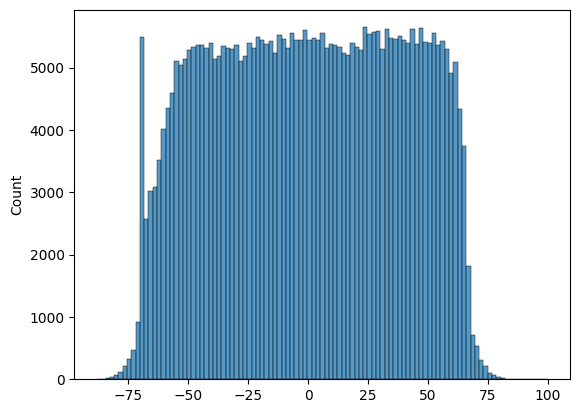

In [75]:
sns.histplot(val_fold['weight_capacity_te'] - val_fold['price'])

In [76]:
test = val_fold.copy()

test['diff'] = (val_fold['weight_capacity_te'] - val_fold['price']).round(3)
test[test['diff'] == -68.632]['price'].value_counts()

price
150.00000    4202
145.73996       1
Name: count, dtype: int64

In [77]:
test[test['diff'] == -68.632]['weight_capacity'].value_counts()

weight_capacity
16.504297    1
21.332981    1
24.929232    1
12.534403    1
19.938567    1
            ..
23.086353    1
6.219927     1
25.086372    1
16.185831    1
21.493738    1
Name: count, Length: 4203, dtype: int64

In [78]:
len(val_fold)

399432

<Axes: xlabel='price', ylabel='Count'>

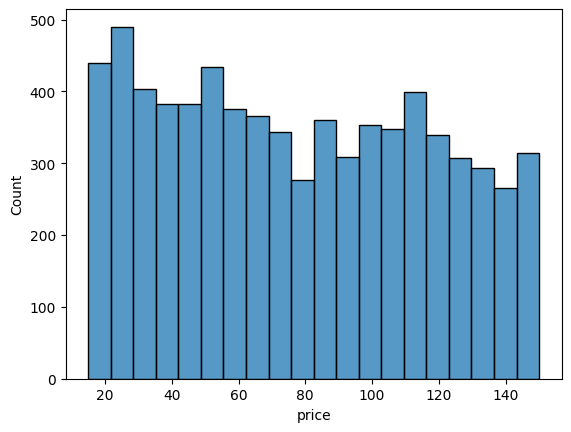

In [79]:
sns.histplot(test[test['weight_capacity'].round() == 5]['price'])

<Axes: xlabel='price', ylabel='Count'>

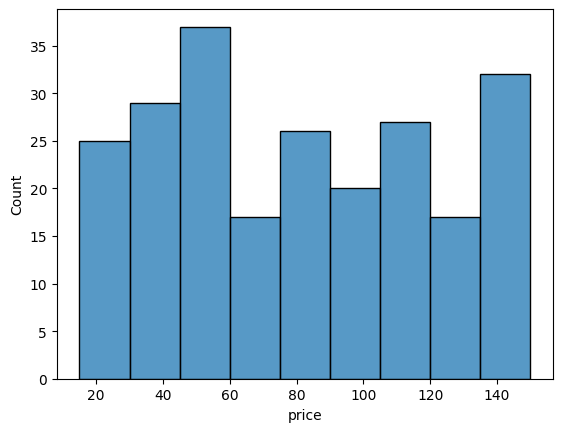

In [80]:
sns.histplot(test[test['weight_capacity'].round(6) == 11.898250]['price'])

In [58]:
test['weight_capacity'].value_counts()

weight_capacity
5.000000     5836
30.000000     282
0.000000      194
11.898250     163
22.898382     158
             ... 
12.294864       1
21.175986       1
26.539291       1
22.657960       1
21.703075       1
Name: count, Length: 232524, dtype: int64

In [56]:
test[test['diff'] == -68.632].sort_values(by='price')

,brand,material,size,compartments,laptop_compartment,is_waterproof,style,color,weight_capacity,price,weight_capacity_te,XGB_1,XGB_2,diff
2311431,Nike,Nylon,2.0,4.0,1,1,Messenger,Green,13.856103,145.73996,77.107540,77.813522,78.210274,-68.632
3982777,Nike,Canvas,1.0,4.0,1,1,Tote,Black,13.629415,150.00000,81.367822,81.730797,81.790222,-68.632
3981791,Jansport,Leather,0.0,1.0,1,0,Tote,Pink,9.659737,150.00000,81.367822,81.730797,81.710922,-68.632
3979559,Nike,Canvas,2.0,7.0,1,0,Backpack,Gray,27.691444,150.00000,81.367822,81.730797,81.903358,-68.632
3977234,Nike,Canvas,2.0,1.0,0,0,Tote,Black,22.637278,150.00000,81.367822,81.730797,81.710922,-68.632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3987379,Under Armour,Leather,0.0,10.0,0,1,Messenger,Pink,10.944821,150.00000,81.367822,81.730797,81.781754,-68.632
3988504,Puma,Leather,0.0,10.0,1,0,Backpack,Gray,6.936883,150.00000,81.367822,81.730797,81.781754,-68.632
3989324,Under Armour,Polyester,0.0,3.0,1,1,Tote,NaN,7.938498,150.00000,81.367822,81.730797,81.622475,-68.632
3989799,Puma,Canvas,2.0,2.0,0,1,Tote,Black,16.504297,150.00000,81.367822,81.730797,81.901863,-68.632


In [50]:
(val_fold['weight_capacity_te'] - val_fold['price']).round(5).value_counts()

-68.63218    4202
 66.36782     545
-71.90697      90
 63.09303      16
 43.95656      15
             ... 
-16.04589       1
 42.16791       1
-26.23751       1
-19.04577       1
-51.41803       1
Name: count, Length: 259488, dtype: int64

In [45]:
(val_fold['weight_capacity_te'] - val_fold['price']).value_counts()

-68.632178    4202
 66.367822     545
-71.906965      90
 63.093035      16
 43.956562      15
              ... 
 13.836411       1
-9.929327        1
 56.462085       1
-66.195880       1
 37.087552       1
Name: count, Length: 261839, dtype: int64

In [32]:
root_mean_squared_error(val_fold['XGB_1'], val_fold['price'])

38.70348389851849

In [33]:
root_mean_squared_error(val_fold['XGB_2'], val_fold['price'])

38.702939994302504

In [34]:
root_mean_squared_error((val_fold['XGB_1'] + val_fold['XGB_2']) / 2, val_fold['price'])

38.702011341423194

<Axes: ylabel='Count'>

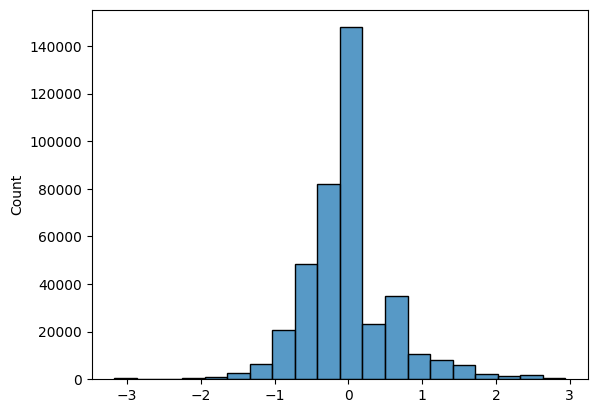

In [31]:
sns.histplot(val_fold['XGB_1'] - val_fold['XGB_2'], bins=20)

## v1

In [21]:
train_df.columns

Index(['brand', 'material', 'size', 'compartments', 'laptop_compartment',
       'is_waterproof', 'style', 'color', 'weight_capacity', 'price'],
      dtype='object')

In [38]:
train_df['weight_capacity_int'] = train_df['weight_capacity'].astype(int)
cols_to_transform = [
    'brand', 'material', 'size', 'compartments', 'laptop_compartment',
    'is_waterproof', 'style', 'color', 'weight_capacity'
]
other_features = ['weight_capacity_int']
# other_features = ['brand']
# cols_to_transform = ['weight_capacity']

In [37]:
# df_stacked[current_features]

In [39]:
all_features = cols_to_transform + other_features

# XGB Model Parameters
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "seed": 42,
    "verbosity": 0,
}

def run_xgb_oof(
    df,
    features,
    target_col,
    n_splits=10,
    params={},
    num_boost_round=200,
    early_stopping_rounds=20
):
    """
    Trains an XGB model in a K-Fold manner and returns:
    - oof_preds: The out-of-fold predictions for each row in df.
    - performance: The RMSE computed on out-of-fold predictions.
    """

    # Prepare array for OOF predictions
    oof_preds = np.zeros(len(df))
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_metrics = []
    
    for fold, (train_idx, valid_idx) in enumerate(kf.split(df), 1):
        train_fold = df.iloc[train_idx].copy()
        valid_fold = df.iloc[valid_idx].copy()
        
        # Fit on the train fold, transform both train and valid
        te = TargetEncoder()
        train_te = te.fit_transform(train_fold[cols_to_transform], train_fold[target_col])
        valid_te = te.transform(valid_fold[cols_to_transform])

        # Convert to DataFrames
        train_te = pd.DataFrame(train_te, columns=cols_to_transform, index=train_fold.index)
        valid_te = pd.DataFrame(valid_te, columns=cols_to_transform, index=valid_fold.index)
        
        # Rebuild the DataFrame with transformed features + numeric
        X_train = pd.concat([train_te, train_fold[other_features]], axis=1)
        y_train = train_fold[target_col].values
        
        X_valid = pd.concat([valid_te, valid_fold[other_features]], axis=1)
        y_valid = valid_fold[target_col].values

        # Convert to XGBoost DMatrix
        dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
        dvalid = xgb.DMatrix(X_valid, label=y_valid, enable_categorical=True)
        
        # Train XGB
        bst = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            evals=[(dtrain, "train"), (dvalid, "valid")],
            early_stopping_rounds=early_stopping_rounds,
            verbose_eval=False
        )

        # Predict on validation fold
        preds_valid = bst.predict(dvalid)
        oof_preds[valid_idx] = preds_valid
        
        # Compute fold RMSE
        fold_rmse = root_mean_squared_error(y_valid, preds_valid)
        fold_metrics.append(fold_rmse)
    
    # Overall OOF RMSE
    overall_rmse = root_mean_squared_error(df[target_col], oof_preds)
    print(f"OOF RMSE: {overall_rmse:.4f}")
    
    return oof_preds, overall_rmse

# Sequentially Build N Models
N = 300  # Number of sequential models to build
best_score = float('inf')
accepted_oof_columns = []  # Which OOF columns we've kept so far

df_stacked = train_df.copy()  # Start from original training set
performance_list = []

for level in range(1, N+1):
    # print(f"\n=== Level {level} ===")
    
    # Decide which features to use. At each level, we include:
    #   - Original features
    #   - All previously-generated OOF prediction columns
    # current_features = all_features + [
    #     col for col in df_stacked.columns 
    #     if col.startswith("xgb_oof_lvl")
    # ]
    current_features = all_features + accepted_oof_columns
    new_oof_col = f"xgb_oof_lvl{level}"


    
    # Run cross-validation and get OOF predictions
    oof_preds, score = run_xgb_oof(
        df_stacked,
        features=current_features,
        target_col=target,
        n_splits=10,
        params=params,
        num_boost_round=200,
        early_stopping_rounds=20
    )
    
    # Append performance
    performance_list.append(score)
    
    # Add these OOF predictions as a new feature for the next level
    # df_stacked[f"xgb_oof_lvl{level}"] = oof_preds
    df_stacked[new_oof_col] = oof_preds
    
    # If performance improved, accept this new feature; otherwise prune
    if score < best_score:
        print(f"Level {level}: New best score achieved: {score:.4f} (previous best was {best_score:.4f})")
        best_score = score
        accepted_oof_columns.append(new_oof_col)
    else:
        print(f"Level {level}: No improvement; pruning column '{new_oof_col}'.")
        # Remove the column from df_stacked
        df_stacked.drop(columns=[new_oof_col], inplace=True)

# Print the performance of each level
for lvl, perf in enumerate(performance_list, 1):
    print(f"Level {lvl} OOF RMSE: {perf:.4f}")


OOF RMSE: 38.6982
Level 1: New best score achieved: 38.6982 (previous best was inf)
OOF RMSE: 38.7011
Level 2: No improvement; pruning column 'xgb_oof_lvl2'.
OOF RMSE: 38.7003
Level 3: No improvement; pruning column 'xgb_oof_lvl3'.
OOF RMSE: 38.7086
Level 4: No improvement; pruning column 'xgb_oof_lvl4'.
OOF RMSE: 38.7052
Level 5: No improvement; pruning column 'xgb_oof_lvl5'.
OOF RMSE: 38.6979
Level 6: New best score achieved: 38.6979 (previous best was 38.6982)
OOF RMSE: 38.6989
Level 7: No improvement; pruning column 'xgb_oof_lvl7'.
OOF RMSE: 38.7017
Level 8: No improvement; pruning column 'xgb_oof_lvl8'.
OOF RMSE: 38.7000
Level 9: No improvement; pruning column 'xgb_oof_lvl9'.
OOF RMSE: 38.6994
Level 10: No improvement; pruning column 'xgb_oof_lvl10'.
OOF RMSE: 38.6989
Level 11: No improvement; pruning column 'xgb_oof_lvl11'.
OOF RMSE: 38.6990
Level 12: No improvement; pruning column 'xgb_oof_lvl12'.
OOF RMSE: 38.6988
Level 13: No improvement; pruning column 'xgb_oof_lvl13'.
OOF RM

<Axes: >

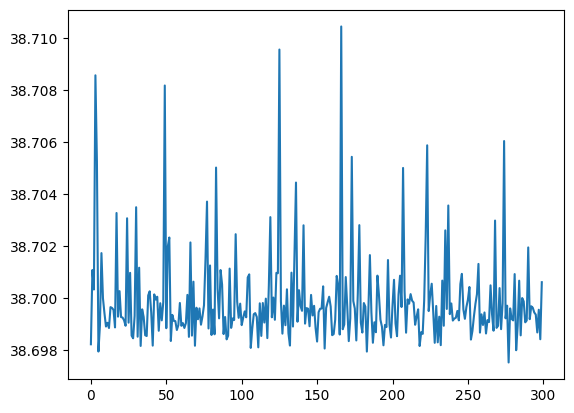

In [40]:
sns.lineplot(performance_list)

In [14]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
data_splits = []

for train_index, val_index in kf.split(train_df):
    train_fold = train_df.iloc[train_index]
    val_fold = train_df.iloc[val_index]

    te = TargetEncoder(target_type="continuous", smooth=20)
    train_te = te.fit_transform(train_fold[cols_to_transform], train_fold[target])
    val_te = te.transform(val_fold[cols_to_transform])

    # Convert to DataFrames
    train_te = pd.DataFrame(train_te, columns=cols_to_transform, index=train_fold.index)
    val_te = pd.DataFrame(val_te, columns=cols_to_transform, index=val_fold.index)
    
    train_te[target] = train_fold[target]
    val_te[target] = val_fold[target]

    data_splits.append((train_te, val_te))

    # dtrain = xgb.DMatrix(train_te, label=train_fold[target], enable_categorical=True)
    # dvalid = xgb.DMatrix(val_te, label=val_fold[target], enable_categorical=True)

In [ ]:
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "seed": 42,
    "verbosity": 0,
}


results = {name: [] for name in ['baseline', 'stacked']}

for i, (train_fold, valid_fold) in enumerate(data_splits, 1):
    dtrain = xgb.DMatrix(train_fold[cols_to_transform], label=train_fold[target], enable_categorical=True)
    dvalid = xgb.DMatrix(valid_fold[cols_to_transform], label=val_fold[target], enable_categorical=True)

    bst = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=200,
        evals=[(dtrain, "train"), (dvalid, "validation")],
        early_stopping_rounds=20,
        verbose_eval=False,
    )
    
    y_pred = bst.predict(dvalid)
    rmse = root_mean_squared_error(dvalid.get_label(), y_pred)
    results['baseline'].append(rmse)



ValueError: All arrays must be of the same length

In [ ]:
pd.DataFrame(results)

In [16]:
train_fold[cols_to_transform]

,weight_capacity
0,78.891189
1,81.351436
2,81.458312
3,81.362671
4,81.458312
...,...
299994,83.379240
299996,81.450312
299997,76.974541
299998,81.385971
